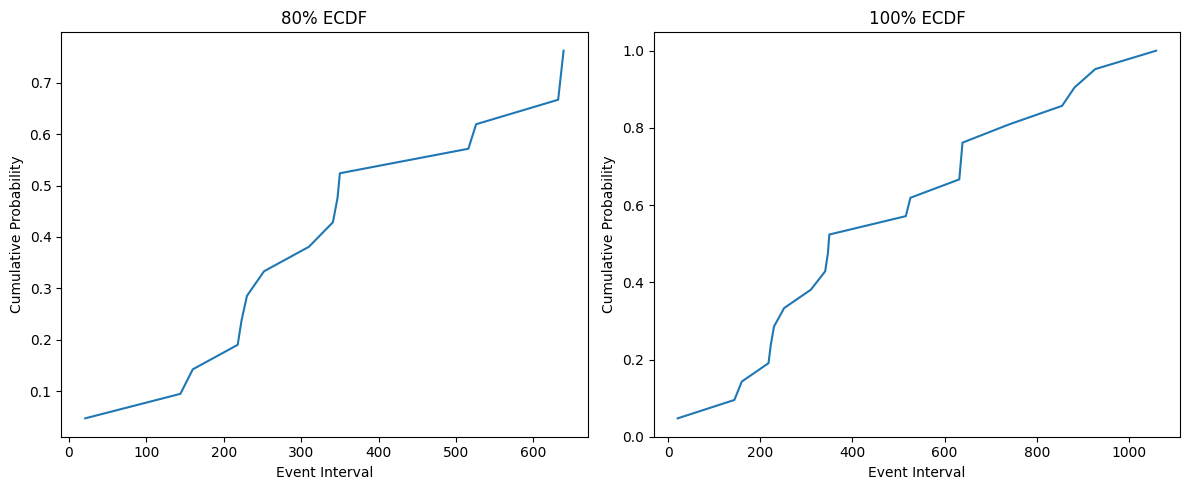

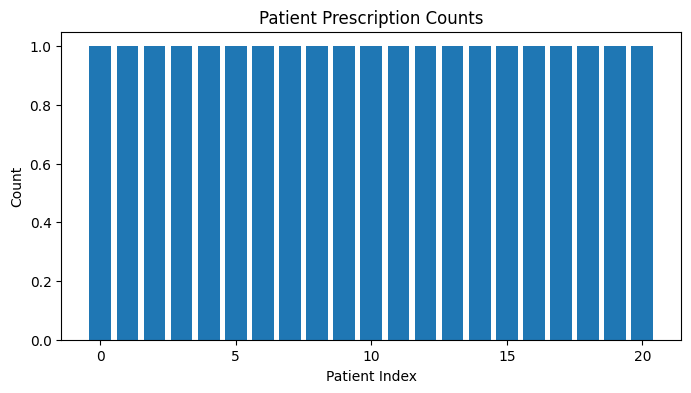

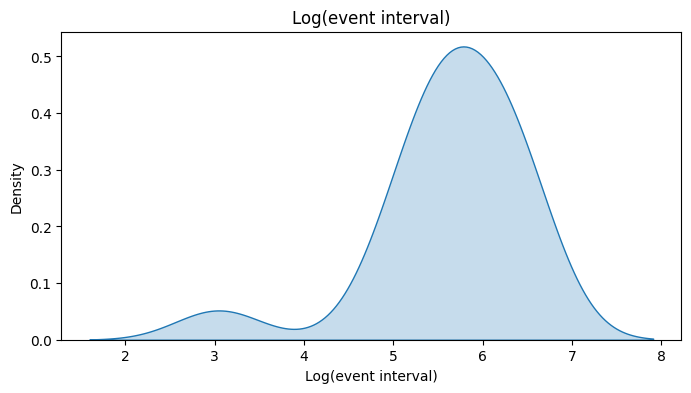

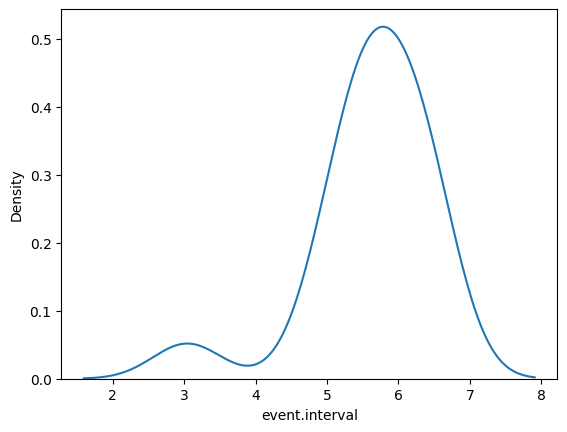

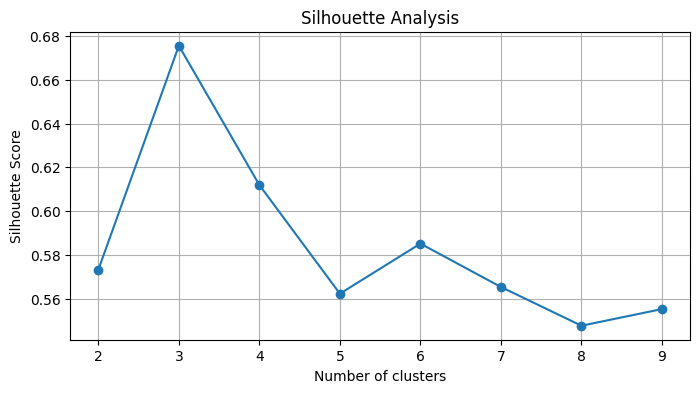

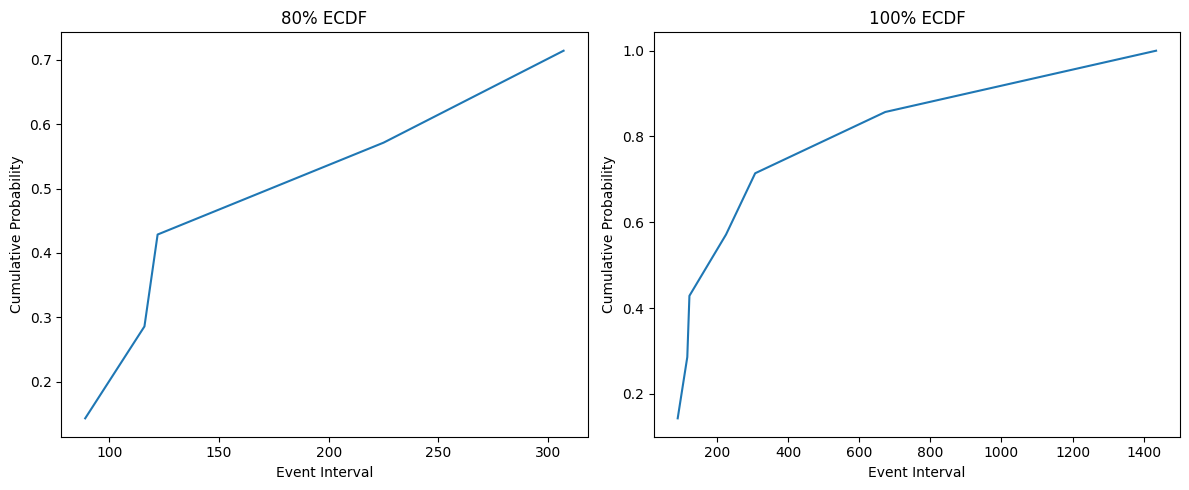

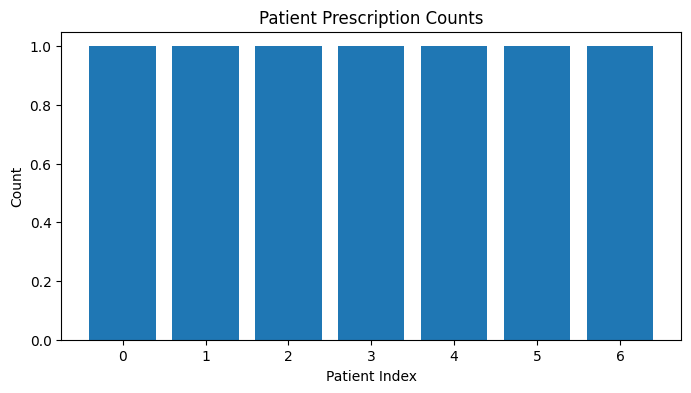

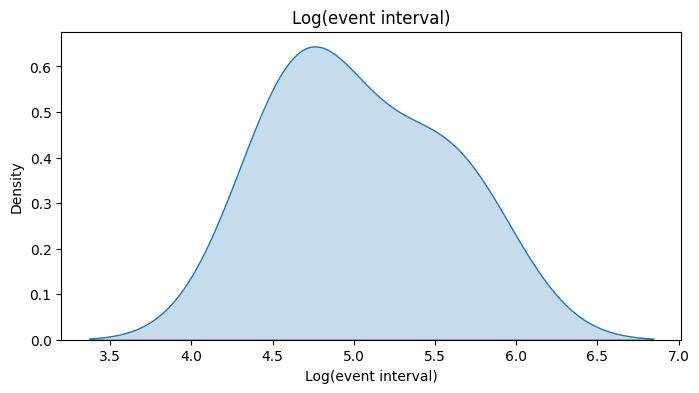

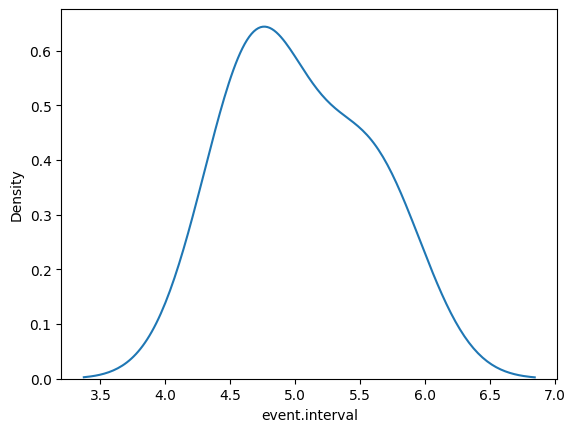

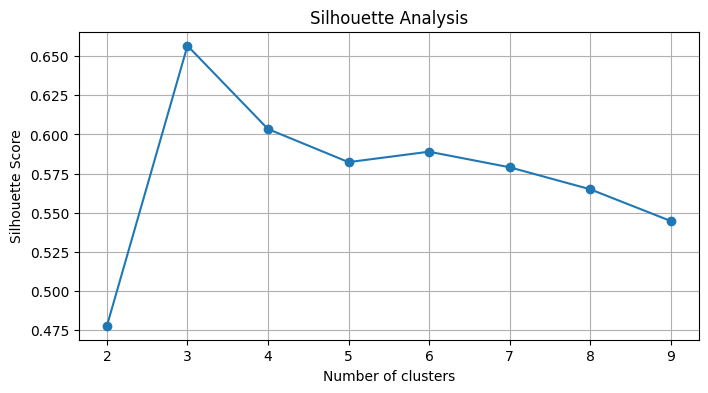

Analysis complete. Plots saved as medA_assumption.png and medB_assumption.png


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from datetime import datetime
import random
from statsmodels.distributions.empirical_distribution import ECDF

# Assuming med_events is already loaded as a pandas DataFrame
# If not, you would load it with something like:
# med_events = pd.read_csv('med_events.csv')

def convert_to_date(date_str):
    """Convert string date to datetime object"""
    try:
        return pd.to_datetime(date_str, format='%m/%d/%Y')
    except:
        return pd.NaT

def See(arg1, tidy):
    """
    Analyze medication adherence patterns
    
    Parameters:
    arg1 (str): The medication code to analyze
    tidy (DataFrame): The preprocessed medication data
    
    Returns:
    DataFrame: Processed data with adherence metrics
    """
    # Filter data for the specific medication
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    
    # Take a random sequence of consecutive prescription in the dataset
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()
    
    # Sort and calculate previous prescription date
    Drug_see_p1 = Drug_see_p1.sort_values(['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    
    # Remove rows with no previous prescription
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    
    # Sample one prescription per patient
    patient_samples = []
    for pnr, group in Drug_see_p1.groupby('pnr'):
        if len(group) > 0:
            patient_samples.append(group.sample(n=1))
    
    Drug_see_p1 = pd.concat(patient_samples, ignore_index=True)
    
    # Keep only needed columns
    Drug_see_p1 = Drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    
    # Calculate interval between prescriptions
    Drug_see_p1['event.interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days
    
    # Generate ECDF data
    event_intervals = Drug_see_p1['event.interval'].values
    ecdf = ECDF(event_intervals)
    x = np.sort(event_intervals)
    y = ecdf(x)
    
    # Create DataFrame for ECDF
    dfper = pd.DataFrame({'x': x, 'y': y})
    
    # Retain the 80% of the ECDF (removing upper 20%)
    dfper = dfper[dfper['y'] <= 0.8].copy()
    
    # Plotting ECDF (equivalent to R's plots)
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(dfper['x'], dfper['y'])
    plt.title("80% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("Cumulative Probability")
    
    plt.subplot(1, 2, 2)
    plt.plot(x, y)
    plt.title("100% ECDF")
    plt.xlabel("Event Interval")
    plt.ylabel("Cumulative Probability")
    
    plt.tight_layout()
    plt.show()
    
    # Calculate patient frequencies
    m1 = Drug_see_p1['pnr'].value_counts()
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(m1)), m1.values)
    plt.title("Patient Prescription Counts")
    plt.xlabel("Patient Index")
    plt.ylabel("Count")
    plt.show()
    
    # Get maximum interval from 80% ECDF
    ni = dfper['x'].max()
    
    # Filter to events within interval threshold
    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event.interval'] <= ni].copy()
    
    # Create density plot of log event intervals
    log_intervals = np.log(Drug_see_p2['event.interval'].astype(float))
    
    plt.figure(figsize=(8, 4))
    sns.kdeplot(log_intervals, fill=True)
    plt.title("Log(event interval)")
    plt.xlabel("Log(event interval)")
    plt.ylabel("Density")
    plt.show()
    
    # Prepare data for silhouette analysis
    density_data = sns.kdeplot(log_intervals).get_lines()[0].get_data()
    x1, y1 = density_data
    a = np.column_stack((x1, y1))
    a = stats.zscore(a, axis=0)  # Scale the data
    
    # Silhouette Score analysis for optimal number of clusters
    np.random.seed(1234)  # for reproducibility
    range_n_clusters = range(2, 10)
    silhouette_avg_list = []
    
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_avg_list.append(silhouette_avg)
    
    plt.figure(figsize=(8, 4))
    plt.plot(range_n_clusters, silhouette_avg_list, 'o-')
    plt.title('Silhouette Analysis')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()
    
    # Get optimal number of clusters
    max_cluster = range_n_clusters[np.argmax(silhouette_avg_list)]
    
    # K-means Clustering on event intervals
    np.random.seed(1234)
    kmeans = KMeans(n_clusters=max_cluster, random_state=1234)
    dfper['cluster'] = kmeans.fit_predict(dfper[['x']].values)
    
    # Calculate statistics by cluster
    cluster_stats = dfper.groupby('cluster')['x'].agg([
        ('min_log', lambda x: np.log(x.min()) if x.min() > 0 else 0),
        ('max_log', lambda x: np.log(x.max())),
        ('median_log', lambda x: np.log(x.median()))
    ]).reset_index()
    
    # Replace -inf with 0 for min_log values
    cluster_stats['min_log'] = cluster_stats['min_log'].replace(-np.inf, 0)
    
    # Convert back from log scale
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    
    # Only keep positive median values
    nif = cluster_stats[cluster_stats['Median'] > 0].copy()
    nif = nif[['cluster', 'Minimum', 'Maximum', 'Median']]
    nif.rename(columns={'cluster': 'Cluster'}, inplace=True)
    
    # Create cartesian product (equivalent to cross_join in R)
    results = pd.merge(
        Drug_see_p1.assign(key=1),
        nif.assign(key=1),
        on='key'
    ).drop('key', axis=1)
    
    # Determine final cluster
    results['Final_cluster'] = np.where(
        (results['event.interval'] >= results['Minimum']) & 
        (results['event.interval'] <= results['Maximum']),
        results['Cluster'],
        np.nan
    )
    
    # Drop rows with no assigned cluster
    results = results.dropna(subset=['Final_cluster'])
    
    # Select relevant columns
    results = results[['pnr', 'Median', 'Cluster']]
    
    # Get most frequent cluster
    t1 = pd.DataFrame({'Cluster': [results['Cluster'].value_counts().index[0]]})
    t1['Cluster'] = t1['Cluster'].astype(float)
    
    # Get first row of merged data with most frequent cluster
    t1_merged = pd.merge(t1, results, on='Cluster').iloc[0:1]
    t1 = t1_merged[['pnr', 'Median']].copy()
    
    # Merge results back to original data
    Drug_see_p1 = pd.merge(Drug_see_p1, results, on='pnr', how='left')
    
    # Fill missing values with values from most frequent cluster
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p1['Cluster'] = Drug_see_p1['Cluster'].fillna(0)
    
    # Additional calculations
    Drug_see_p1['event.interval'] = Drug_see_p1['event.interval'].astype(float)
    Drug_see_p1['test'] = np.round(Drug_see_p1['event.interval'] - Drug_see_p1['Median'], 1)
    
    # Create subset with only needed columns
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'Cluster']].copy()
    
    # Assign Duration
    Drug_see_p0 = pd.merge(Drug_see_p0, Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].astype(float)
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1['Median'].iloc[0])
    Drug_see_p0['Cluster'] = Drug_see_p0['Cluster'].fillna(0)
    
    return Drug_see_p0

def see_assumption(arg1):
    """
    Analyze prescription patterns with boxplots
    
    Parameters:
    arg1 (DataFrame): Medication data to analyze
    
    Returns:
    matplotlib.figure: Boxplot figure
    """
    # Sort data and calculate previous dates
    arg1 = arg1.sort_values(['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    # Create prescription sequence
    Drug_see2 = arg1.copy()
    Drug_see2 = Drug_see2.sort_values(['pnr', 'eksd'])
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1
    
    # Filter to 2nd and later prescriptions
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2].copy()
    Drug_see2 = Drug_see2[['pnr', 'eksd', 'prev_eksd', 'p_number']]
    
    # Calculate duration between prescriptions
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    
    # Convert p_number to categorical for plotting
    Drug_see2['p_number'] = Drug_see2['p_number'].astype(str)
    
    # Calculate patient-level median durations
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().reset_index()
    
    # Calculate overall median for plotting
    overall_median = medians_of_medians['Duration'].median()
    
    # Create boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(y=overall_median, color='red', linestyle='--')
    plt.title('Prescription Intervals by Prescription Number')
    plt.xlabel('Prescription Number')
    plt.ylabel('Duration (days)')
    plt.grid(True, alpha=0.3)
    
    return plt.gcf()  # Return the current figure

# Example usage
# First preprocess the data
def preprocess_data(example_pats):
    """Preprocess the medication data"""
    tidy = example_pats.copy()
    tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
    tidy['eksd'] = tidy['eksd'].apply(convert_to_date)
    return tidy

# This part would be executed when running the script
if __name__ == "__main__":
    # Assuming med_events is loaded
    # med_events = pd.read_csv('med_events.csv')  # Uncomment and modify as needed
    
    # For demonstration, create a sample dataframe similar to med.events in R
    # In a real scenario, you would load your actual data
    med_events = pd.DataFrame({
        'pnr': np.random.randint(1000, 9999, 1000),
        'eksd': [f"{random.randint(1, 12)}/{random.randint(1, 28)}/{random.randint(2020, 2023)}" for _ in range(1000)],
        'perday': np.random.uniform(1, 3, 1000),
        'ATC': np.random.choice(['medA', 'medB'], 1000),
        'dur_original': np.random.randint(30, 180, 1000)
    })
    
    # Preprocess the data
    tidy = preprocess_data(med_events)
    
    # Run the analysis
    medA = See("medA", tidy)
    medB = See("medB", tidy)
    
    # Generate assumption plots
    figure1 = see_assumption(medA)
    plt.savefig('medA_assumption.png')
    
    plt.close()
    
    figure2 = see_assumption(medB)
    plt.savefig('medB_assumption.png')
    plt.close()
    
    print("Analysis complete. Plots saved as medA_assumption.png and medB_assumption.png")